# Multi $\kappa$ Scale Factor
This applies the scale factor theory to all simulations, through regression.

In [1]:
import copy
import sys
import os

from isca_tools.plot.base import fig_resize

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.convection.base import lapse_moist, lapse_dry
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms, get_p_x, get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.adiabat_theory2 import get_approx_terms, get_scale_factor_theory, get_sensitivity_factors, decompose_var_x_change, get_cape_approx
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.plot import label_subplots, fig_resize, update_linewidth, update_fontsize
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
import warnings
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [2]:
fig_data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/land/meridional_band/publish_figures/paper_fig_data/egu_2025_talk/'
load_data = True
is_land_data = False         # Whether to load in land or aquaplanet data, only used in load_data is False


plot_info = {'aquaplanet': {}, 'land': {}}
if load_data:
    data_load = np.load(os.path.join(fig_data_dir, 'aquaplanet.npz'), allow_pickle=True)
    plot_info['aquaplanet'] = {key: dict(data_load[key]) for key in data_load.files}['data']
    data_load = np.load(os.path.join(fig_data_dir, 'land.npz'), allow_pickle=True)
    plot_info['land'] = {key: dict(data_load[key]) for key in data_load.files}['data']
    print('Data in plot_info loaded from:\n{}'.format(fig_data_dir))
else:
    if is_land_data:
        exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'       # Land
    else:
        exp_dir = 'tau_sweep/aquaplanet/depth=1/'                                 # Aquaplanet
    print('Data not loaded in, will generate for:\n{}'.format(exp_dir))

Data in plot_info loaded from:
/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/land/meridional_band/publish_figures/paper_fig_data/egu_2025_talk/


In [3]:
# If true, will save ALL figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5, 'two_thirds': 4.5}        # width in inches
save_pad_inches = 0.05

leg_info = {'handlelength': 1, 'labelspacing': 0.2, 'columnspacing': 0.9, 'handletextpad': 0.5}       # info for legend
def add_legend(ax, handles=None, labels=None, ncol=1, title=None, loc=None, frameon=False, edgecolor="k", borderpad=None,
               labelspacing=leg_info['labelspacing'], handlelength=leg_info['handlelength'],
               columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad']):
    if handles is None:
        return ax.legend(ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                 labelspacing=labelspacing, handlelength=handlelength,
                 columnspacing=columnspacing, handletextpad=handletextpad)
    else:
        return ax.legend(handles, labels, ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                         labelspacing=labelspacing, handlelength=handlelength,
                         columnspacing=columnspacing, handletextpad=handletextpad)


# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']
#
# labels_exp = ['$\kappa={:.1f}$'.format(tau_lw[i]) for i in range(n_kappa)]

In [4]:
if not load_data:
    # Load dataset - one at surface and one in free troposphere
    var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
    use_time_start = 360*2
    pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

    kappa_names = ['k=1', 'k=1_5']
    kappa_names.sort()
    n_kappa = len(kappa_names)

    ds = []
    albedo = []
    tau_sw = []
    tau_lw = []
    with tqdm(total=n_kappa, position=0, leave=True) as pbar:
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]

            ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
            namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
            albedo += [namelist['mixed_layer_nml']['albedo_value']]
            tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
            tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
            pbar.update(1)
    tau_lw = np.asarray(tau_lw)
    pfull = ds_use.pfull
    ind_surf = 0
    ind_ft = 1
    p_surface = float(ds[0].pfull[ind_surf]) * 100
    pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
    n_pressure = ds[0].pfull.size
    # sigma_half reflects ds_us.pfull (starts with 0 - space, ends with 1 - surface)
    sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
    sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')       # sigma levels corresponding to pressure levels
else:
    tau_lw = plot_info['land']['tau_lw']
    n_kappa = len(tau_lw)
    ind_surf = np.argmax(plot_info['land']['pressure'])
    ind_ft = np.argmin(plot_info['land']['pressure'])
    p_surface = plot_info['land']['pressure'][ind_surf]
    pressure_ft_actual = plot_info['land']['pressure'][ind_ft]
    n_pressure = len(plot_info['land']['pressure'])     # should be 2
    namelist = isca_tools.load_namelist(plot_info['land']['exp_dir'] + 'k=1')
    sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
    sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')       # sigma levels corresponding to pressure levels
R_mod = get_theory_prefactor_terms(0, p_surface, pressure_ft_actual)[0]   # need to compute mse_mod

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [5]:
# Show where the land is
if not load_data:
    save_land_fig = False

    job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
    land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
    if is_land_data != os.path.exists(land_file_name):
        raise ValueError('Land data not found at {}'.format(land_file_name))
    if is_land_data:
        fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
        isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
        lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

        if save_land_fig:
            isca_tools.savefig(fig, 'land_coords', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)






### Get Average of Variables
Get average values of various quantities required for scaling factor theory.

In [6]:
if load_data:
    lat = plot_info['land']['lat']
    n_lat = len(lat)
    lat_weights = np.cos(np.deg2rad(lat))
else:
    # Load in across all latitudes, for given season
    # Select region to combine latitudes over for all but one of the plots below
    # Tropics
    region = 'tropics'
    lat_min = 0
    lat_max = 20
    # Extratropics
    # region = 'extratropics'
    # lat_min = 40
    # lat_max = 65
    # lat_min = 70
    # lat_max = 90

    # Chose whether to only consider summer days or consider all days
    # season = 'all'
    season = 'summer'
    # season = 'winter'
    if season == 'summer':
        if region == 'tropics':
            season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}
        else:
            season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
    elif season == 'winter':
        if region == 'tropics':
            season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
        else:
            season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]}

    lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
    n_lat = len(lat_use_ind)
    lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]
    lat = ds[0].lat[lat_use_ind].to_numpy()

    # Whether to do taylor expansion about mean over just land or mean over whole planet
    mean_method = 'land'
    # mean_method = 'all'

    temp_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
    z_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
    r_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
    epsilon_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
    z_approx_error_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}        # error in z used in mse_mod approx
    # Decide how to compute humidities - do q first and then r from this ('sphum'), or vice versa ('r')?

    ds_all = []
    with tqdm(total=n_kappa, position=0, leave=True) as pbar:
        for j in range(n_kappa):
            ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory

            if is_land_data:
                # if not aquaplanet, then is land and only consider land longitudes
                ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

            if season in ['summer', 'winter']:
                ds_nh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))
                ds_sh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0))
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_sh_season, ds_nh_season], dim='lat')
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            ds_all += [ds_use.load()]

            if mean_method == 'all':
                ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
                ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            elif mean_method != 'land':
                raise ValueError(f'Mean method is {mean_method} which is not valid.')
            temp_av['mean'][j] = ds_use.temp.mean(dim='lon_time')
            temp_av['median'][j] = ds_use.temp.median(dim='lon_time')
            z_av['mean'][j] = ds_use.height.mean(dim='lon_time')
            z_av['median'][j] = ds_use.height.mean(dim='lon_time')
            rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
            r_av['mean'][j] = rh_use.mean(dim='lon_time')
            r_av['median'][j] = rh_use.median(dim='lon_time')
            mse_use_surf = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=ds_use.height.isel(pfull=ind_surf))
            mse_use_ft = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                             height=ds_use.height.isel(pfull=ind_ft))
            epsilon_use = mse_use_surf-mse_use_ft
            epsilon_av['mean'][j] = epsilon_use.mean(dim='lon_time')
            epsilon_av['median'][j] = epsilon_use.median(dim='lon_time')
            mse_mod_use = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=0, c_p_const=c_p-R_mod
                                              ) - epsilon_use
            mse_mod_use_ft_approx = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                                        height=0, c_p_const=c_p+R_mod)
            z_error_use = mse_mod_use - mse_mod_use_ft_approx
            z_approx_error_av['mean'][j] = z_error_use.mean(dim='lon_time')
            z_approx_error_av['median'][j] = z_error_use.median(dim='lon_time')
            pbar.update(1)

### Get quantile variables
Get variables required for scaling factor theory conditioned on near-surface percentile, $x$, in `_quant3` arrays. Also, get actual distribution of some variables in `_quant` arrays.

In [7]:
def get_cape_approx_quant(temp_surf, rh, temp_ft, epsilon, quant, pressure_surf=p_surface, pressure_ft=pressure_ft_actual, batch_size=1000):
    # Computes approx cape from 1D arrays of temp_surf, rh, temp_ft, epsilon
    # Then computes quantiles of resultant cape array
    # Expect large array hence, give batch size to make more efficient
    use_ind = np.where(~np.isnan(temp_surf))[0]         # only consider non-nan elements
    cape_all = np.zeros(use_ind.size)
    ind_batches = np.array_split(np.arange(use_ind.size), np.ceil(use_ind.size / batch_size))
    for ind in ind_batches:
        cape_all[ind] = get_cape_approx(temp_surf[use_ind[ind]], rh[use_ind[ind]], pressure_surf, pressure_ft,
                                        temp_ft[use_ind[ind]], epsilon[use_ind[ind]])[0]
    return np.quantile(cape_all, quant)     # units are kJ/kg

In [8]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
if load_data:
    quant_plot = plot_info['land']['quant_plot']
    n_quant = len(quant_plot)
if not load_data:
    quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
    n_quant = len(quant_plot)
    # quant3 is conditioned on near-surface temperature
    temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
    sphum_quant3 = np.zeros((n_kappa, n_lat, n_quant))
    z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))



    with tqdm(total=n_kappa*n_lat, position=0, leave=True) as pbar:
        for j in range(n_kappa):
            ds_use = ds_all[j]
            rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
            mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]),
                       moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
            mse_mod_use = moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), height=0, c_p_const=c_p + R_mod)
            epsilon_use = mse_use[0] - mse_use[1]
            for k in range(n_lat):
                for q, quant in enumerate(quant_plot):
                    use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                    # Make sure to compute temp_quant at FT level using near-surface quantiles
                    temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                    z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                    sphum_quant3[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                pbar.update(1)

    # computed as in get_scaling_factor_theory function in adiabat_theory.py, computing sphum quant first
    # Really doesn't matter though but I think this method is simpler
    # When computing average, I think it does make more sense to compute sphum_av from r_av because theory built around RH
    r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, ind_surf], p_surface)
percentile_label = 'Temperature percentile, $x$'

In [9]:
if not load_data:
    # Copy epsilon calculation from get_scaling_factor_theory function in adiabat_theory.py
    # In units of kJ/kg
    epsilon_quant3 = (moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=z_quant3[:, ind_surf]) -
                     moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft]))

## Reference Climate
In the theory, we are free to choose the reference day, and the change with warming of this day, that the theory is built around. We must specify the reference surface temperature, $\tilde{T}_s$, relative humidity, $\tilde{r}_s$, CAPE proxy, $\tilde{\epsilon}$ and error due to approximation of geopotential height, $\tilde{A}_z$.

Given these three values, we can compute the reference free tropospheric temperature, $\tilde{T}_{FT}$, by equating two equations for reference modified MSE, $\tilde{h}^{\dagger}$:

$\tilde{h}^{\dagger} = (c_p - R^{\dagger})\tilde{T}_s + L_v \tilde{q}_s - \epsilon = (c_p + R^{\dagger})\tilde{T}_{FT} + L_vq^*(\tilde{T}_{FT}, p_{FT})
 + \tilde{A}_z$

Where we use the computed average error due to z approximation, $\tilde{A}_z$ in this computation of $\tilde{T}_{FT}$.

For ease of interpretation later, I propose:
* $\tilde{T}_s = \overline{T_s}; \delta \tilde{T}_s = \delta \overline{T_s}$
* $\tilde{r}_s = \overline{r_s}; \delta \tilde{r}_s = 0$
* $\tilde{\epsilon} = 0; \delta \tilde{\epsilon} = 0$
* $\tilde{A}_z = \overline{A}_z; \delta \tilde{A}_z = 0$

where the overline refers to the time-zonal median value of that quantity. Median because for talk it is easier to grasp visually when all lines go through x=50.

In [10]:
if not load_data:
    av_use = 'median'
    # Use median for EGU talk, so all go through x=50 point in graph, and easier to explain
    r_ref = r_av[av_use]
    epsilon_ref = np.zeros((n_kappa, n_lat))        # Normalise relative to day with zero CAPE in each simulation         # use actual average epsilon
    temp_surf_ref = temp_av[av_use][:, ind_surf] # Have actual average surface temperature change with warming
    z_approx_error_ref = np.zeros((n_kappa, n_lat))
    cape_ref = np.zeros((n_kappa, n_lat))

### Figure - Changing $T_s$ with warming
Show the $T_s$ distribution for each simulation, to indicate land distribution widens, but aquaplanet does the opposite.

In [11]:
if not load_data:
    # Add 1st data to plot_info required for plotting
    zero_plot_info_arrays = {'exp_dir': '', 'tau_lw': np.asarray([]), 'av_use': '', 'quant_plot': np.asarray([]),
                             'pressure': np.zeros(n_pressure), 'lat': np.zeros(n_lat),
                             'temp_s_anom': np.zeros_like(temp_quant3[:, ind_surf]),
                             'temp_s_av': np.zeros((n_kappa, n_lat)), 'r_av': np.zeros((n_kappa, n_lat)),
                             'temp_quant3': np.zeros((n_kappa, n_pressure, n_lat, n_quant)),
                             'r_quant3': np.zeros((n_kappa, n_lat, n_quant)),
                             'r_ref': np.zeros((n_kappa, n_lat)),
                             'epsilon_ref': np.zeros((n_kappa, n_lat)),
                             'temp_surf_ref': np.zeros((n_kappa, n_lat)),
                             'z_approx_error_ref': np.zeros((n_kappa, n_lat)),
                             'klzbs_quant3': np.zeros((n_kappa, n_lat, n_quant)),
                             }
    # First initialise arrays as zero, if don't exist already
    for key in ['aquaplanet', 'land']:
        for key2 in zero_plot_info_arrays:
            try:
                plot_info[key][key2]       # just to key exists
            except KeyError:
                # If variable doesn't exist, create it with all values set to 0
                plot_info[key][key2] = copy.deepcopy(zero_plot_info_arrays[key2])

    # Add data for current dataset
    plot_info['land' if is_land_data else 'aquaplanet']['exp_dir'] = exp_dir      # record experiment used
    plot_info['land' if is_land_data else 'aquaplanet']['tau_lw'] = tau_lw        # record kappa values used
    plot_info['land' if is_land_data else 'aquaplanet']['av_use'] = av_use        # averaging method used
    plot_info['land' if is_land_data else 'aquaplanet']['quant_plot'] = quant_plot   # averaging method used
    plot_info['land' if is_land_data else 'aquaplanet']['pressure'][[ind_surf, ind_ft]] = [p_surface, pressure_ft_actual]       # record pressure values
    plot_info['land' if is_land_data else 'aquaplanet']['lat'] = lat
    plot_info['land' if is_land_data else 'aquaplanet']['temp_s_anom'] = temp_quant3[:, ind_surf] - temp_av[av_use][:, ind_surf, :, np.newaxis]
    plot_info['land' if is_land_data else 'aquaplanet']['temp_s_av'] = temp_av[av_use][:, ind_surf]
    plot_info['land' if is_land_data else 'aquaplanet']['r_av'] = r_av[av_use]
    # Save all quantile and ref data for future reference
    plot_info['land' if is_land_data else 'aquaplanet']['temp_quant3'] = temp_quant3
    plot_info['land' if is_land_data else 'aquaplanet']['r_quant3'] = r_quant3
    plot_info['land' if is_land_data else 'aquaplanet']['r_ref'] = r_ref
    plot_info['land' if is_land_data else 'aquaplanet']['epsilon_ref'] = epsilon_ref
    plot_info['land' if is_land_data else 'aquaplanet']['temp_surf_ref'] = temp_surf_ref
    plot_info['land' if is_land_data else 'aquaplanet']['z_approx_error_ref'] = z_approx_error_ref

In [12]:
if not load_data:
    # delta_temp_quant_theory[0] will be all zeros and never used, but helpful to keep this shape
    sf_simulated = np.diff(temp_quant3[:, ind_surf], axis=0).squeeze() / np.diff(temp_surf_ref, axis=0).squeeze()[:, np.newaxis]
    sf_theory = np.zeros((n_lat, n_quant))
    sf_theory_cont = {key: np.zeros((n_lat, n_quant)) for key in ['temp_ft_change', 'r_change', 'cape_change',
                                                                                'temp_anom', 'r_anom']}
    sf_theory_approx = {key: np.zeros((n_lat, n_quant)) for key in
                        ['temp_ft_anom_change', 'temp_s_anom_change', 'r_change', 'temp_s_anom_r_change', 'anom_temp_s_r',
                         'anom', 'ref_change', 'z_anom_change', 'nl', 'cape']}

    for i in tqdm(range(n_lat)):
        sf_theory[i], gamma_use, _, var = \
                get_scale_factor_theory(temp_surf_ref[:, i], temp_quant3[:, ind_surf, i], r_ref[:, i], r_quant3[:, i],
                                        temp_quant3[:, ind_ft, i], epsilon_quant3[:, i], p_surface,
                                        pressure_ft_actual, epsilon_ref[:, i], z_approx_error_ref[:, i],
                                        include_non_linear=False, cape_form=True)
        for key in sf_theory_cont:
            sf_theory_cont[key][i] = var[key]
        # Get approx info
        var = get_approx_terms(temp_surf_ref[:, i], temp_quant3[:, ind_surf, i], r_ref[:, i], r_quant3[:, i],
                               temp_quant3[:, ind_ft, i], epsilon_quant3[:, i], p_surface, pressure_ft_actual,
                               epsilon_ref[:, i], z_approx_error_ref[:, i], cape_form=True)[0]
        for key in sf_theory_approx:
            sf_theory_approx[key][i] = var[key]

### Figure - Scaling Factor
Here we show the scaling factor, and two versions of the theory. One is the linear version, and the second is the linear version if we break down the change mechanisms into distribution change and percentile change contributions.

In [13]:
# Combine data required for plotting from aquaplanet and land into 1 dictionary
# Need to run through notebook twice (one with aquaplanet data loaded, one with land data loaded) to get final dict

# arrays below are just all zero with correct size to initialise plot_info entries
if not load_data:
    zero_plot_info_arrays = {'sf': np.zeros_like(sf_simulated),
                             'sf_theory': np.zeros_like(sf_theory),
                             'sf_theory_cont': {key2: np.zeros_like(sf_theory_cont[key2]) for key2 in sf_theory_cont},
                             'sf_theory_approx': {key2: np.zeros_like(sf_theory_approx[key2]) for key2 in sf_theory_approx}}
    for key in ['aquaplanet', 'land']:
        for key2 in ['sf', 'sf_theory', 'sf_theory_cont', 'sf_theory_approx']:
            try:
                plot_info[key][key2]       # just to key exists
            except KeyError:
                # If variable doesn't exist, create it with all values set to 0
                plot_info[key][key2] = copy.deepcopy(zero_plot_info_arrays[key2])

    # Update plot dict for current loaded simulation
    plot_info['land' if is_land_data else 'aquaplanet']['sf'][:] = sf_simulated
    plot_info['land' if is_land_data else 'aquaplanet']['sf_theory'][:] = sf_theory
    for key in sf_theory_cont:
        plot_info['land' if is_land_data else 'aquaplanet']['sf_theory_cont'][key][:] = sf_theory_cont[key]
    for key in sf_theory_approx:
        plot_info['land' if is_land_data else 'aquaplanet']['sf_theory_approx'][key][:] = sf_theory_approx[key]

In [14]:
quant_median_ind = np.where(quant_plot==50)[0][0]

def plot_sf(var, ax_lat=0, lat_weights=lat_weights, ax_quant=1, norm_by_median=True, median_ind=quant_median_ind):
    if norm_by_median:
        return np.average(var - np.take(var, indices=[median_ind], axis=ax_quant) + 1, axis=ax_lat, weights=lat_weights)
    else:
        return np.average(var, axis=ax_lat, weights=lat_weights)

colors_cont = {'temp_anom': default_colors[3], 'r_anom': default_colors[4],
               'r_change': default_colors[0], 'temp_ft_change': default_colors[2], 'cape_change': default_colors[1]}

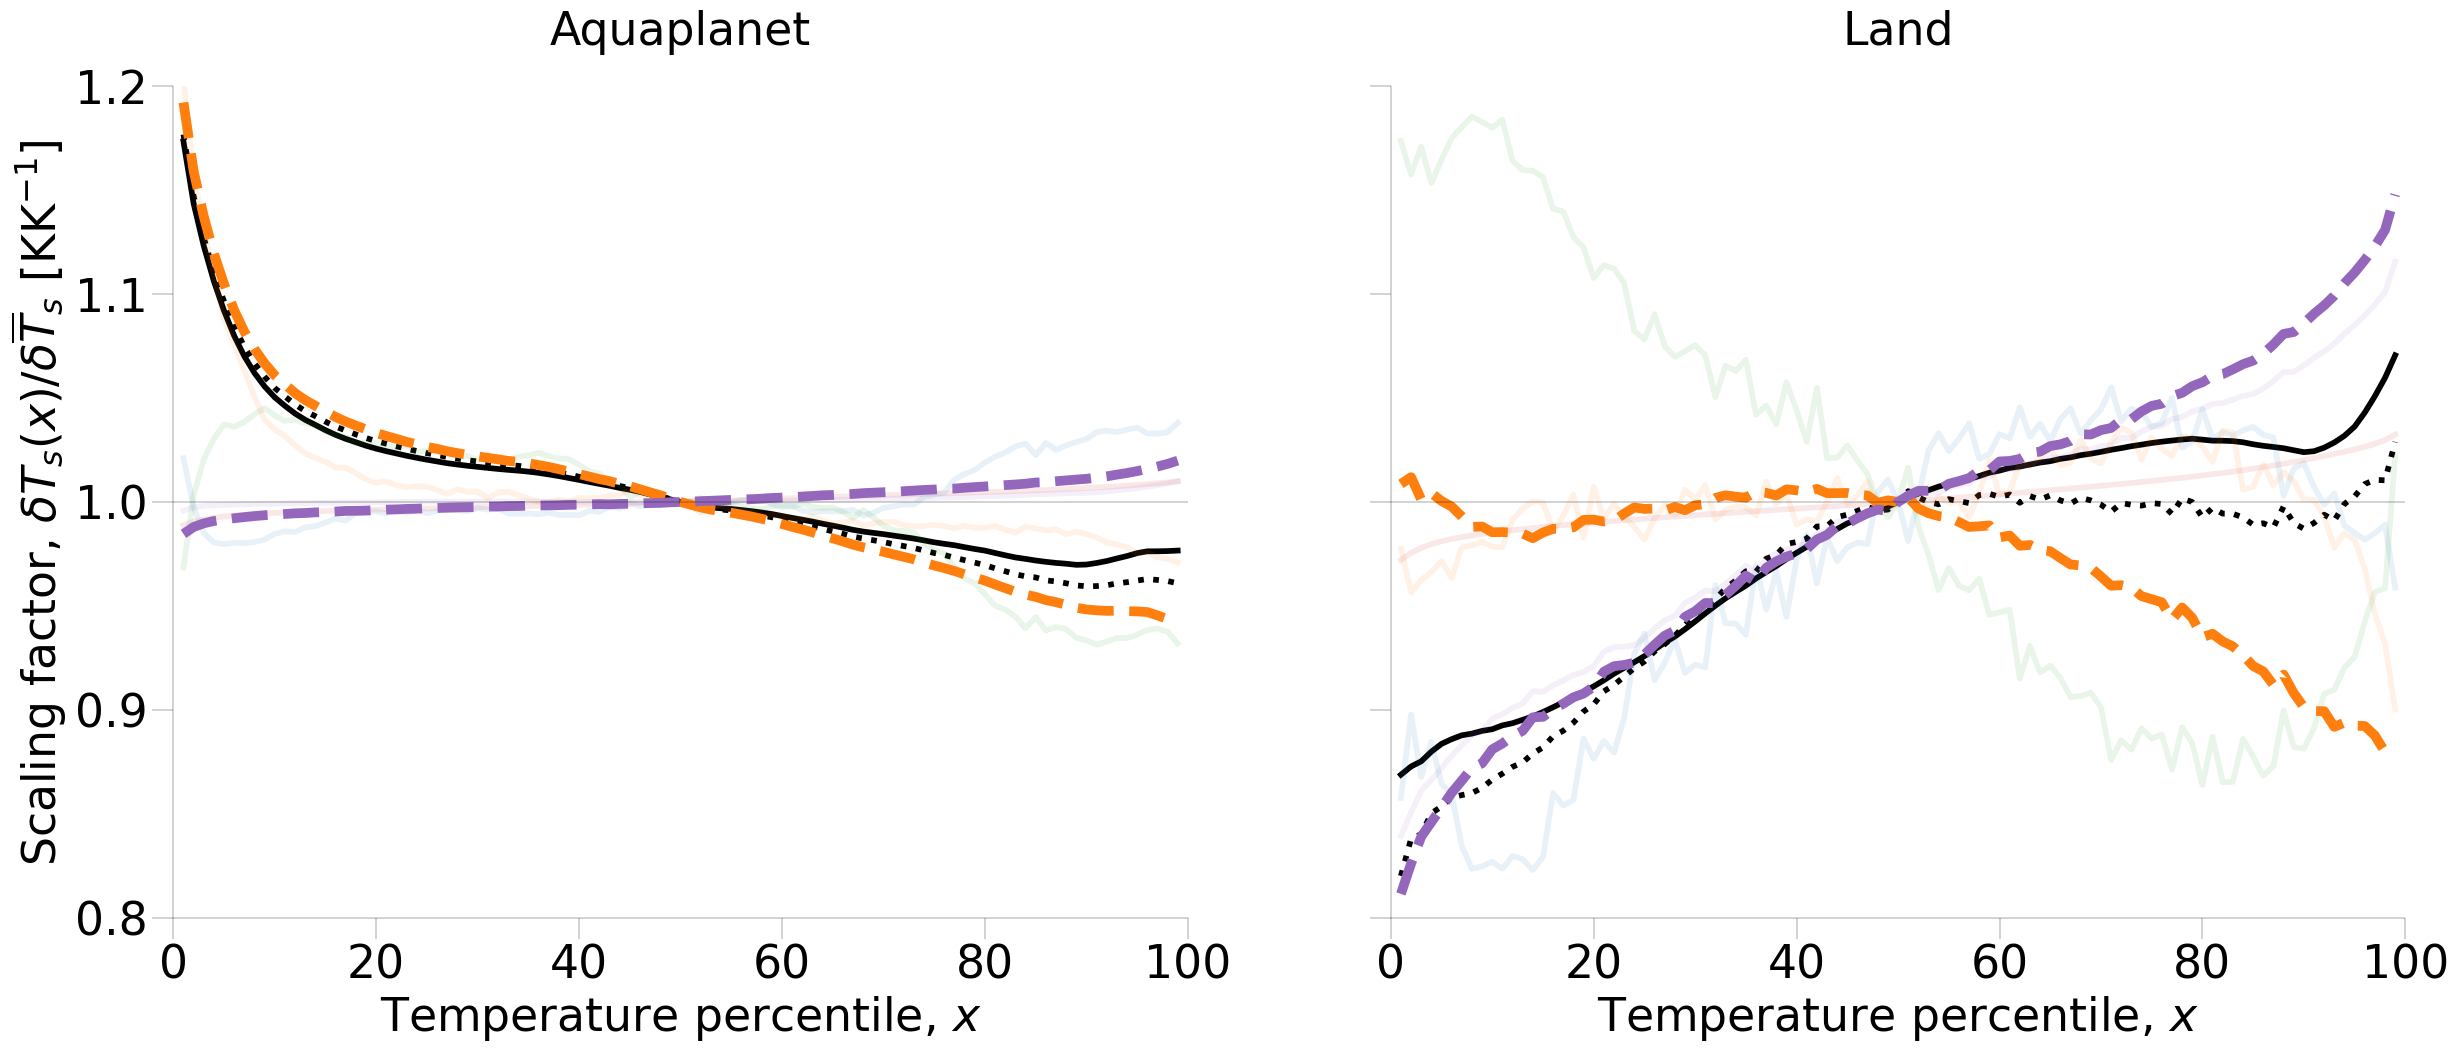

In [15]:
plot_no = 8       # add lines for each figure. Then at the end, combine change and anomalous mechanisms
im_sz = 4.5
norm_median = True     # force all lines through x=50
save_sf_theory_fig = False
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
fig_resize(fig, width['one_col']*2*im_sz)
line_change_width = []
for j, key in enumerate(plot_info):
    ax[j].plot(quant_plot, plot_sf(plot_info[key]['sf'], norm_by_median=norm_median), color='k')
    if plot_no >= 1:
        ax[j].plot(quant_plot, plot_sf(plot_info[key]['sf_theory'], norm_by_median=norm_median), color='k', linestyle=':')
        for k, key2 in enumerate(colors_cont):
            if plot_no <= k+1:
                continue
            if plot_no == len(plot_info[key]['sf_theory_cont']) + 2 and 'change' in key2:
                alpha_use = 0.1
            elif plot_no >= len(plot_info[key]['sf_theory_cont']) + 3:
                alpha_use = 0.1
            else:
                alpha_use = 1
            ax[j].plot(quant_plot, plot_sf(plot_info[key]['sf_theory_cont'][key2], norm_by_median=norm_median),
                       color=colors_cont[key2], alpha=alpha_use)
    if plot_no >= len(plot_info[key]['sf_theory_cont']) + 2:
        line, = ax[j].plot(quant_plot, plot_sf(sum([plot_info[key]['sf_theory_cont'][key2] for key2 in plot_info[key]['sf_theory_cont']
                                                    if 'change' in key2]), norm_by_median=norm_median), linestyle='--', color=colors_cont['cape_change'])
        line_change_width.append(line)
    if plot_no >= len(plot_info[key]['sf_theory_cont']) + 3:
        line, = ax[j].plot(quant_plot, plot_sf(sum([plot_info[key]['sf_theory_cont'][key2] for key2 in plot_info[key]['sf_theory_cont']
                                                    if 'anom' in key2]), norm_by_median=norm_median), linestyle='--', color=colors_cont['r_anom'])
        line_change_width.append(line)
    ax[j].set_xlabel('Temperature percentile, $x$')
    ax[j].set_title(key.capitalize(), y=1.04)
ax[0].set_xlim(0,100)
ylim_sf = [0.8, 1.2]                    # use here and for fixed evap figure below
ytick_sf = np.arange(0.8, 1.3, 0.1)     # use here and for fixed evap figure below
ax[0].set_ylim(ylim_sf)
ax[0].set_yticks(ytick_sf)
ax[0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')
update_linewidth(fig)
update_fontsize(fig)
ax[0].axhline(1, linewidth=ax_linewidth, color='k')
ax[1].axhline(1, linewidth=ax_linewidth, color='k')

for line in line_change_width:
    line.set_linewidth(7)

# Update tick parameters
ax[0].tick_params(length=15, direction='out')
ax[1].tick_params(length=15, direction='out')

plt.show()
if save_sf_theory_fig or save_fig:
    isca_tools.savefig(fig, f'sf_theory{plot_no+1}', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight',
                       pad_inches=save_pad_inches, save_if_exists=False)

### Figure - Approx
Here we show the approximations associated with the theory, highlighting the 3 large approximations in the land simulations in solid lines. The sum is show by a solid black line.

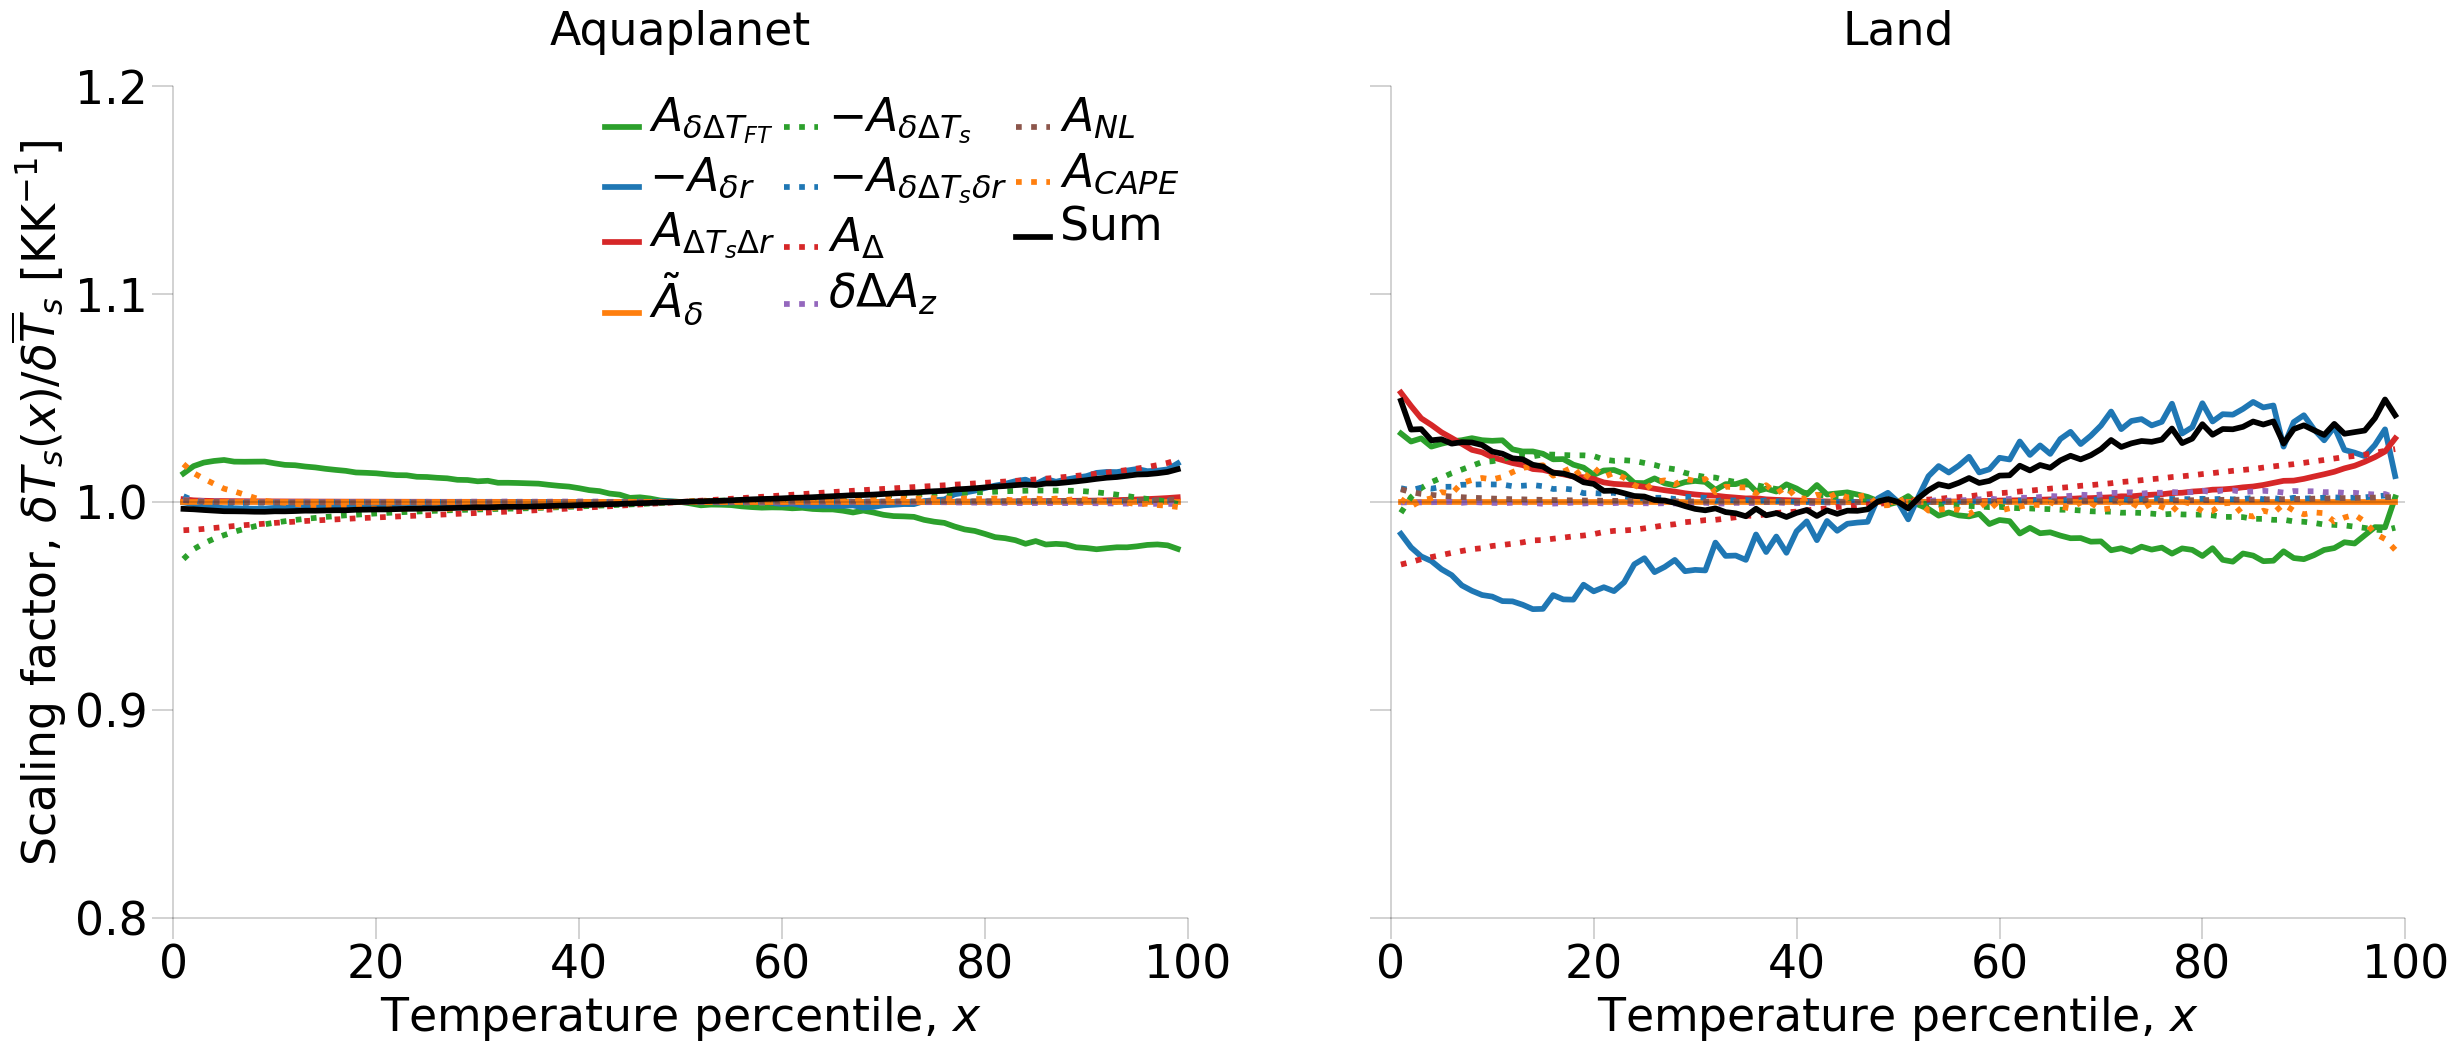

In [31]:
colors_approx = {'temp_ft_anom_change': default_colors[2], 'r_change': default_colors[0], 'anom_temp_s_r': default_colors[3],
                 'ref_change': default_colors[1],
                 'temp_s_anom_change': default_colors[2], 'temp_s_anom_r_change': default_colors[0], 'anom': default_colors[3],
                 'z_anom_change': default_colors[4], 'nl': default_colors[5], 'cape': default_colors[1]}
linestyles_approx = {'temp_ft_anom_change': None, 'r_change': None, 'anom_temp_s_r': None, 'ref_change': None,
                     'temp_s_anom_change': ':', 'temp_s_anom_r_change': ':', 'z_anom_change': ':', 'anom': ':', 'nl': ':', 'cape': ':'}
labels_approx = {'temp_ft_anom_change': '$A_{\delta \Delta T_{FT}}$', 'r_change': '$-A_{\delta r}$', 'anom_temp_s_r': '$A_{\Delta T_s \Delta r}$',
                 'ref_change': '$\\tilde{A}_{\delta}$', 'temp_s_anom_change': '$-A_{\delta \Delta T_s}$',
                 'temp_s_anom_r_change': '$-A_{\delta \Delta T_s \delta r}$', 'z_anom_change': '$\delta \Delta A_z$',
                 'anom': '$A_{\Delta}$', 'nl': '$A_{NL}$', 'cape': '$A_{CAPE}$'}
label_use = ['$A_{\delta \Delta T_{FT}}-A_{\delta r}+A_{\Delta T_s \Delta r}+\\tilde{A}_{\delta}$',
             '$A_{\delta \Delta T_s}+A_{\delta \Delta T_s \delta r}+A_{\Delta}+\\tilde{A}_{\delta}+\delta \Delta A_z+A_{NL}$']

save_sf_approx_fig = False
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
fig_resize(fig, width['one_col']*2*im_sz)
for j, key2 in enumerate(plot_info):
    for key in colors_approx:
        ax[j].plot(quant_plot, plot_sf(plot_info[key2]['sf_theory_approx'][key], norm_by_median=norm_median),
                   color=colors_approx[key], label=labels_approx[key] if j==0 else None, linestyle=linestyles_approx[key])
    ax[j].set_xlabel('Temperature percentile, $x$')
    ax[j].set_title(key2.capitalize(), y=1.04)
    ax[j].plot(quant_plot, plot_sf(sum([plot_info[key2]['sf_theory_approx'][key] for key in plot_info[key2]['sf_theory_approx']]),
                                       norm_by_median=norm_median), color='k', label='Sum' if j==0 else None)

ax[0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')
# add_legend(ax[0], ncol=3, loc='upper right')
ax[0].set_xlim(0,100)
# ax[0, 0].set_ylim(0.56, 1.31)
# fig.text(0.5, 0.895, "Aquaplanet", ha='center')
# fig.text(0.5, 0.47, "Land", ha='center')

update_linewidth(fig)
add_legend(ax[0], ncol=3, loc='upper right', handlelength=3.5, labelspacing=1, handletextpad=1)
update_fontsize(fig)
for ax_use in ax.flatten():
    ax_use.axhline(1, color='k', lw=ax_linewidth)

# Update tick parameters
ax[0].tick_params(length=15, direction='out')
ax[1].tick_params(length=15, direction='out')
ax[0].set_ylim(ylim_sf)
ax[0].set_yticks(ytick_sf)

plt.show()
if save_sf_approx_fig or save_fig:
    isca_tools.savefig(fig, 'sf_approx', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

# fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
# for j, key2 in enumerate(plot_info):
#     for key in colors_approx:
#         ax[j].plot(quant_plot, 1+np.average(plot_info[key2]['sf_theory_approx'][key][2], axis=0, weights=lat_weights),
#                 color=colors_approx[key], label=labels_approx[key], linestyle=linestyles_approx[key])
#     ax[j].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][2] for key in linestyles_approx if linestyles_approx[key]==None]),
#                                         axis=0, weights=lat_weights),
#                 color='k')
#     ax[j].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][2] for key in linestyles_approx if linestyles_approx[key]!=None]),
#                                         axis=0, weights=lat_weights),
#                 color='k', linestyle='--')
#     ax[j].axhline(1, color='k', lw=ax_linewidth)
#     ax[j].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$, contribution')
# # ax[0].set_ylim(0.7, 1.3)
# ax[0].legend(ncol=3)

In [17]:
save_data = False
if save_data:
    if is_land_data:
        save_file = os.path.join(fig_data_dir, 'land.npz')
    else:
        save_file = os.path.join(fig_data_dir, 'aquaplanet.npz')
    if os.path.exists(save_file):
        print('File already exists:\n{}'.format(save_file))
    else:
        np.savez_compressed(save_file, data=np.array(list(plot_info['land' if is_land_data else 'aquaplanet'].items()), dtype=object))
        print("plot_info[{}] saved to\n{}".format("'land'" if is_land_data else "'aquaplanet'", save_file))